# Travail final: Analyse d'un sous corpus portant sur les jeux olympique de 1924 

Dans ce notebook, nous étudions de manière transversale l'enssemble du sous corpus Camile extrait.

## Imports

In [1]:
# === IMPORTS ===

import os
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Traitement du langage
import spacy
from spacy.lang.fr.stop_words import STOP_WORDS
from collections import Counter

# NLP avancé
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Word embeddings
from gensim.models import Word2Vec

# Nettoyage
import re
import string

# Affichage
sns.set(style="whitegrid")


In [18]:
# pd.set_option("display.max_colwidth", None)
# pd.set_option("display.max_rows", 200)
# pd.set_option("display.max_colwidth", 2000)  # pour éviter les coupures


## Chargement et exploration du sous corpus

In [15]:
# --- Chargement du corpus CAMille (Jeux Olympiques 1924) ---

import pandas as pd
from pathlib import Path

# Chemin du fichier (à adapter si différent)
data_path = Path("data/camille_Jeux_olympiques.xlsx")

# Chargement du fichier Excel
df = pd.read_excel(data_path)

# Aperçu des premières lignes
df.head()


,ID,JOURNAL,DATE,ANNÉE,MOIS,JOUR,JDLS,ÉDITION,PAGE,LANGUE,TEXTE
0,KB_JB838_1924-07-11_01-00005,JB838,1924-07-11,1924,7,11,5,1,5,fr-BE,"Seul 1e Marathon des Flandres n’aura pas lieu, à. cause dos <kw>Jeux</kw> <kw>Olympiques</kw>. Celui-ci sera disputé fin du mois d'août. Le programme de la fête athlétique comportera le3 épreuves suivantes: ; , 1. Critérium international de vitesse: a) 100 m. plat; b) 150 m. plat; c) 200 m. plat, par addition de points'obtenus dans chacune de ce3 épreuves. La participation do Cockuyt et JBrochart est déjà certaine.--Des’pourparlers sont engagés aveo deux -excellents sprintera étrangers. 2. Challenge du Kilomètre. ;— Classement par trois hommes dû mémo cercle. 3. Challenge des relais. — a) Bêlais suédois (400, : 300, 200 ot 100 ui.);'. b) Bêlais olympique (1,600, 600, 400. 200 m.); c) 800 m. relaie (4xzoo m.). I 4. 5,000 mètres scratch, classement spécial par > trois hommes, pour clubs de déuxième catégorie, ~ -jdoté d'un eliallcngc. 5. 200 mètres, scratch, pour deuxième catégorie. 6 .Challenge des concours: a) Lancement du disque; : b) Lancement du javelot; 'c) Lancement du poids; d) 8aut en longueur; e) Saut h la perobo. 7. Challenge des espoirs, réservé aux scolaires: a) 100 m. plat; b) 400 m. plat; c) 1,000 m. plat; 'd) Lancement du poids (1 bras). Ce programme, admirable par son originalité, doit satisfaire Je3 plus difficiles. * - Lè concours de tous les meilleurs athlètes belges est -dès A présent assuré, et comme chaque année, le Stadium de l’A. B. A. G. connaîtra la foule des grands jduis. A L'UNION SPORTIVE DE GOSSELIES L’Union Sportive de Gosselies organise le lundi Cl juillet 1924 (Fête’a Nationales), A deux heures et i demie de l'après-midi, sur le magnifique terrain de ,1a rue de Jumot, un grand meeting d’athlétisme -/réservé aux athlètes de seconde catégorie, - débu- tr.nts et scolaires, affiliés à la Ligue Belge d'Atb- Jétisme. ’ Au programme figurent los épreuves suivantes: 100 m., 400"" m., 1,600 in., 5,000 m., 1,000 m. scolaires, saut en hauteur, lancement du disque, 800 m. [...] Aux côtés des Américains figureront tencore les meilleurs athlètes..."
1,KB_JB838_1924-06-30_01-00001,JB838,1924-06-30,1924,6,30,1,1,1,fr-BE,"Paris est en pleines Olympiades, ce qui signifie que les <kw>Jeux</kw> <kw>Olympiques</kw> ont lieu, cette année, en France, sur les stades de Colombes, ville de banlieue dont Paris est pour l’hèure une annexe. . Les hellénistes ne sont pas contents, parce que Olympiades, en grec, signifie une période de temps marquée par le retour des <kw>jeux</kw> d’Olympie, et non pas les <kw>jeux</kw> eux-mêmes. Mais les Hellénistes ne sont jamais contents : iis devraient l’être, car la restitution des <kw>Jeux</kw>. <kw>Olympiques</kw> est unè belle chose, curieuse, et un hommage du sport moderne à l’antiquité. Pour une fois que la langue du sport ne parle pas anglais et.emprunte le grec, ne nous fâchons pas! Pour reconstituer les <kw>jeux</kw> universels, il a fallu établir une méthode et une. organisation dans le monde entier : des règles, des épreuves dans tous les pays,' des éliminatoires enfin, surveillées par des associations; bref, une Internationale sportive/qui assure.l’uni-- té et les correspondances entre les sections nationales. Or, .ce caractère international, ce fut justement un des premiers traits des <kw>jeux</kw> helléniques, et spécialement des <kw>Jeux</kw> <kw>Olympiques</kw>. Evidemment, les Grecs n’eritendaient pas l'Internationale comme nous: Mais cette distinction de l’internationalisme antique et du moderne est,?.\à la. vérité,' , une,/différence d’étendue, une différence quantitative, beaucoup plus qu’une différence de fond. Le monde grec était tout petit, si nous le comparons au nôtre, mais il était bien plus morcelé, composé de cités et non pas d’Etats, et la question des relations entre ces cités ennemies dans l’intérieur de l'Hellade, la conception même dé l’Hellade, des guerres, des allian- Vous verrez que Bruxelles finira par être à ces, des 

In [3]:
# Ajouter une colonne 'nb_mots' basée sur le texte
df["nb_mots"] = df["TEXTE"].str.split().str.len()

# Longueur moyenne
longueur_moy = df["nb_mots"].mean()

print(f"Longueur moyenne des articles : {longueur_moy:.2f} mots")


Longueur moyenne des articles : 507.15 mots


In [4]:
# Affichage de quelques texte bruts
# Exemple de 3 textes bruts
for i, txt in enumerate(df["TEXTE"].head(3)):
    print(f"\n--- TEXTE {i+1} ---\n")
    print(txt)



--- TEXTE 1 ---

Seul 1e Marathon des Flandres n’aura pas lieu, à. cause dos <kw>Jeux</kw> <kw>Olympiques</kw>. Celui-ci sera disputé fin du mois d'août. Le programme de la fête athlétique comportera le3 épreuves suivantes: ; , 1. Critérium international de vitesse: a) 100 m. plat; b) 150 m. plat; c) 200 m. plat, par addition de points'obtenus dans chacune de ce3 épreuves. La participation do Cockuyt et JBrochart est déjà certaine.--Des’pourparlers sont engagés aveo deux -excellents sprintera étrangers. 2. Challenge du Kilomètre. ;— Classement par trois hommes dû mémo cercle. 3. Challenge des relais. — a) Bêlais suédois (400, : 300, 200 ot 100 ui.);'. b) Bêlais olympique (1,600, 600, 400. 200 m.); c) 800 m. relaie (4xzoo m.). I 4. 5,000 mètres scratch, classement spécial par > trois hommes, pour clubs de déuxième catégorie, ~ -jdoté d'un eliallcngc. 5. 200 mètres, scratch, pour deuxième catégorie. 6 .Challenge des concours: a) Lancement du disque; : b) Lancement du javelot; 'c) Lancem

# Nétoyage et préparation du texte

In [5]:
df.columns


Index(['ID', 'JOURNAL', 'DATE', 'ANNÉE', 'MOIS', 'JOUR', 'JDLS', 'ÉDITION',
       'PAGE', 'LANGUE', 'TEXTE', 'nb_mots'],
      dtype='object')

In [6]:
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Stopwords FR
stopwords_fr = set(stopwords.words("french"))

def clean_text(text):
    if pd.isna(text):
        return ""
    
    # Minuscule
    text = text.lower()
    
    # Suppression ponctuation + chiffres
    text = re.sub(r"[^a-zàâçéèêëîïôûùüÿñæœ\s-]", " ", text)
    
    # Supprimer les tirets isolés
    text = re.sub(r"\s-\s", " ", text)
    
    # Tokenisation
    tokens = word_tokenize(text, language="french")
    
    # Suppression stopwords
    tokens = [t for t in tokens if t not in stopwords_fr and len(t) > 2]
    
    return " ".join(tokens)


In [16]:
# Application du nettoyage a notre dataframe
df["clean_text"] = df["TEXTE"].apply(clean_text)
df[["TEXTE", "clean_text"]].head()


,TEXTE,clean_text
0,"Seul 1e Marathon des Flandres n’aura pas lieu, à. cause dos <kw>Jeux</kw> <kw>Olympiques</kw>. Celui-ci sera disputé fin du mois d'août. Le programme de la fête athlétique comportera le3 épreuves suivantes: ; , 1. Critérium international de vitesse: a) 100 m. plat; b) 150 m. plat; c) 200 m. plat, par addition de points'obtenus dans chacune de ce3 épreuves. La participation do Cockuyt et JBrochart est déjà certaine.--Des’pourparlers sont engagés aveo deux -excellents sprintera étrangers. 2. Challenge du Kilomètre. ;— Classement par trois hommes dû mémo cercle. 3. Challenge des relais. — a) Bêlais suédois (400, : 300, 200 ot 100 ui.);'. b) Bêlais olympique (1,600, 600, 400. 200 m.); c) 800 m. relaie (4xzoo m.). I 4. 5,000 mètres scratch, classement spécial par > trois hommes, pour clubs de déuxième catégorie, ~ -jdoté d'un eliallcngc. 5. 200 mètres, scratch, pour deuxième catégorie. 6 .Challenge des concours: a) Lancement du disque; : b) Lancement du javelot; 'c) Lancement du poids; d) 8aut en longueur; e) Saut h la perobo. 7. Challenge des espoirs, réservé aux scolaires: a) 100 m. plat; b) 400 m. plat; c) 1,000 m. plat; 'd) Lancement du poids (1 bras). Ce programme, admirable par son originalité, doit satisfaire Je3 plus difficiles. * - Lè concours de tous les meilleurs athlètes belges est -dès A présent assuré, et comme chaque année, le Stadium de l’A. B. A. G. connaîtra la foule des grands jduis. A L'UNION SPORTIVE DE GOSSELIES L’Union Sportive de Gosselies organise le lundi Cl juillet 1924 (Fête’a Nationales), A deux heures et i demie de l'après-midi, sur le magnifique terrain de ,1a rue de Jumot, un grand meeting d’athlétisme -/réservé aux athlètes de seconde catégorie, - débu- tr.nts et scolaires, affiliés à la Ligue Belge d'Atb- Jétisme. ’ Au programme figurent los épreuves suivantes: 100 m., 400"" m., 1,600 in., 5,000 m., 1,000 m. scolaires, saut en hauteur, lancement du disque, 800 m. [...] Aux côtés des Américains figureront tencore les meilleurs athlètes...",seul marathon flandres lieu cause dos jeux olympiques celui-ci disputé fin mois août programme fête athlétique comportera épreuves suivantes critérium international vitesse plat plat plat addition points obtenus chacune épreuves participation cockuyt jbrochart déjà certaine pourparlers engagés aveo deux -excellents sprintera étrangers challenge kilomètre classement trois hommes mémo cercle challenge relais bêlais suédois bêlais olympique relaie xzoo mètres scratch classement spécial trois hommes clubs déuxième catégorie -jdoté eliallcngc mètres scratch deuxième catégorie challenge concours lancement disque lancement javelot lancement poids aut longueur saut perobo challenge espoirs réservé scolaires plat plat plat lancement poids bras programme admirable originalité doit satisfaire plus difficiles concours tous meilleurs athlètes belges -dès présent assuré comme chaque année stadium connaîtra foule grands jduis union sportive gosselies union sportive gosselies organise lundi juillet fête nationales deux heures demie après-midi magnifique terrain rue jumot grand meeting athlétisme réservé athlètes seconde catégorie débu- nts scolaires affiliés ligue belge atb- jétisme programme figurent los épreuves suivantes scolaires saut hauteur lancement disque côtés américains figureront tencore meilleurs athlètes français parmi lcs- quels dogrello demi-finaliste mètres meut olympiques fcry champion france mètréis nordiste lfascaux demi-miller philips italie aussi représentée fameux negri ambrosini commo chefs file quant suisse eiio déléguera dehors fichwarzenbach strcbi martin prestigieux half-miller seetnd mètres olympique participations athlètes argon tins tchécoslovaques deux fameux hongrois sonfray et- gero ainsi dire certaines tandis qne exhibition extraordinaires champions finlandais bitola nurmi pohrola myrra lehtoncn oj-dre possibilités autres pourparlers toujours cours notamment faire venir suédois wide comme peut rendre compte cette brève énumér

## Analyse de fréquence

In [8]:
from collections import Counter

# Fusionner tout le texte nettoyé
all_tokens = " ".join(df["clean_text"]).split()

freq_clean = Counter(all_tokens).most_common(30)

freq_clean


[('jeux', 4353),
 ('lutte', 1182),
 ('rue', 1145),
 ('plus', 849),
 ('bruxelles', 795),
 ('mètres', 733),
 ('première', 706),
 ('deux', 681),
 ('olympiques', 649),
 ('bat', 645),
 ('prix', 639),
 ('entre', 625),
 ('deuxième', 593),
 ('cette', 588),
 ('heures', 582),
 ('van', 581),
 ('belgique', 566),
 ('quinzes', 565),
 ('victoire', 547),
 ('jeu', 541),
 ('concours', 540),
 ('tout', 520),
 ('paris', 485),
 ('tous', 483),
 ('très', 483),
 ('après', 482),
 ('bien', 450),
 ('finale', 447),
 ('grand', 438),
 ('contre', 436)]

## Bigrammes

In [10]:
print(df.columns)


Index(['ID', 'JOURNAL', 'DATE', 'ANNÉE', 'MOIS', 'JOUR', 'JDLS', 'ÉDITION',
       'PAGE', 'LANGUE', 'TEXTE', 'nb_mots', 'clean_text'],
      dtype='object')


In [12]:
import itertools
from nltk import bigrams

# Tokenisation de clean_text
df["tokens"] = df["clean_text"].str.split()

# Liste de tokens
all_tokens = list(itertools.chain.from_iterable(df["tokens"]))

# Bigrams
all_bigrams = list(bigrams(all_tokens))

print(all_bigrams[:20])


[('seul', 'marathon'), ('marathon', 'flandres'), ('flandres', 'lieu'), ('lieu', 'cause'), ('cause', 'dos'), ('dos', 'jeux'), ('jeux', 'olympiques'), ('olympiques', 'celui-ci'), ('celui-ci', 'disputé'), ('disputé', 'fin'), ('fin', 'mois'), ('mois', 'août'), ('août', 'programme'), ('programme', 'fête'), ('fête', 'athlétique'), ('athlétique', 'comportera'), ('comportera', 'épreuves'), ('épreuves', 'suivantes'), ('suivantes', 'critérium'), ('critérium', 'international')]


## Extraction de mots clés

In [17]:
import yake

# 1. Instancier l'extracteur de mots-clés
kw_extractor = yake.KeywordExtractor(lan="fr", top=50)

# 2. Appliquer YAKE article par article
def extract_bigrams(text):
    """Retourne les mots-clés à deux mots (bigrammes) extraits par YAKE"""
    if not isinstance(text, str):
        return []
    keywords = kw_extractor.extract_keywords(text)
    bigrams = []
    for kw, score in keywords:
        words = kw.split()
        if len(words) == 2:   # garder uniquement les expressions à deux mots
            bigrams.append(kw)
    return bigrams

# 3. Nouvelle colonne « keywords_bigrammes »
df["keywords_bigrams"] = df["TEXTE"].apply(extract_bigrams)

# 4. Aperçu
df[["TEXTE", "keywords_bigrams"]].head()


,TEXTE,keywords_bigrams
0,"Seul 1e Marathon des Flandres n’aura pas lieu, à. cause dos <kw>Jeux</kw> <kw>Olympiques</kw>. Celui-ci sera disputé fin du mois d'août. Le programme de la fête athlétique comportera le3 épreuves suivantes: ; , 1. Critérium international de vitesse: a) 100 m. plat; b) 150 m. plat; c) 200 m. plat, par addition de points'obtenus dans chacune de ce3 épreuves. La participation do Cockuyt et JBrochart est déjà certaine.--Des’pourparlers sont engagés aveo deux -excellents sprintera étrangers. 2. Challenge du Kilomètre. ;— Classement par trois hommes dû mémo cercle. 3. Challenge des relais. — a) Bêlais suédois (400, : 300, 200 ot 100 ui.);'. b) Bêlais olympique (1,600, 600, 400. 200 m.); c) 800 m. relaie (4xzoo m.). I 4. 5,000 mètres scratch, classement spécial par > trois hommes, pour clubs de déuxième catégorie, ~ -jdoté d'un eliallcngc. 5. 200 mètres, scratch, pour deuxième catégorie. 6 .Challenge des concours: a) Lancement du disque; : b) Lancement du javelot; 'c) Lancement du poids; d) 8aut en longueur; e) Saut h la perobo. 7. Challenge des espoirs, réservé aux scolaires: a) 100 m. plat; b) 400 m. plat; c) 1,000 m. plat; 'd) Lancement du poids (1 bras). Ce programme, admirable par son originalité, doit satisfaire Je3 plus difficiles. * - Lè concours de tous les meilleurs athlètes belges est -dès A présent assuré, et comme chaque année, le Stadium de l’A. B. A. G. connaîtra la foule des grands jduis. A L'UNION SPORTIVE DE GOSSELIES L’Union Sportive de Gosselies organise le lundi Cl juillet 1924 (Fête’a Nationales), A deux heures et i demie de l'après-midi, sur le magnifique terrain de ,1a rue de Jumot, un grand meeting d’athlétisme -/réservé aux athlètes de seconde catégorie, - débu- tr.nts et scolaires, affiliés à la Ligue Belge d'Atb- Jétisme. ’ Au programme figurent los épreuves suivantes: 100 m., 400"" m., 1,600 in., 5,000 m., 1,000 m. scolaires, saut en hauteur, lancement du disque, 800 m. [...] Aux côtés des Américains figureront tencore les meilleurs athlètes...","[Flandres n’aura, cause dos, Olympiades fut, Bêlais olympique, grande lutte, mètres olympique, Daring Club, ire catégorie, grande partie]"
1,"Paris est en pleines Olympiades, ce qui signifie que les <kw>Jeux</kw> <kw>Olympiques</kw> ont lieu, cette année, en France, sur les stades de Colombes, ville de banlieue dont Paris est pour l’hèure une annexe. . Les hellénistes ne sont pas contents, parce que Olympiades, en grec, signifie une période de temps marquée par le retour des <kw>jeux</kw> d’Olympie, et non pas les <kw>jeux</kw> eux-mêmes. Mais les Hellénistes ne sont jamais contents : iis devraient l’être, car la restitution des <kw>Jeux</kw>. <kw>Olympiques</kw> est unè belle chose, curieuse, et un hommage du sport moderne à l’antiquité. Pour une fois que la langue du sport ne parle pas anglais et.emprunte le grec, ne nous fâchons pas! Pour reconstituer les <kw>jeux</kw> universels, il a fallu établir une méthode et une. organisation dans le monde entier : des règles, des épreuves dans tous les pays,' des éliminatoires enfin, surveillées par des associations; bref, une Internationale sportive/qui assure.l’uni-- té et les correspondances entre les sections nationales. Or, .ce caractère international, ce fut justement un des premiers traits des <kw>jeux</kw> helléniques, et spécialement des <kw>Jeux</kw> <kw>Olympiques</kw>. Evidemment, les Grecs n’eritendaient pas l'Internationale comme nous: Mais cette distinction de l’internationalisme antique et du moderne est,?.\à la. vérité,' , une,/différence d’étendue, une différence quantitative, beaucoup plus qu’une différence de fond. Le monde grec était tout petit, si nous le comparons au nôtre, mais il était bien plus morcelé, composé de cités et non pas d’Etats, et la question des relations entre ces cités ennemies dans l’intérieur de l'Hellade, la conception même dé l’Hellade, des guerres, des allian- Vous verrez que Bruxelles finira par être à ces, des obligations communes à tous les i. j

## Nuage de Mots (Wordcloud)

In [21]:
from collections import Counter

# Concaténer tous les textes nettoyés du corpus
full_clean_text = " ".join(df["clean_text"].dropna())

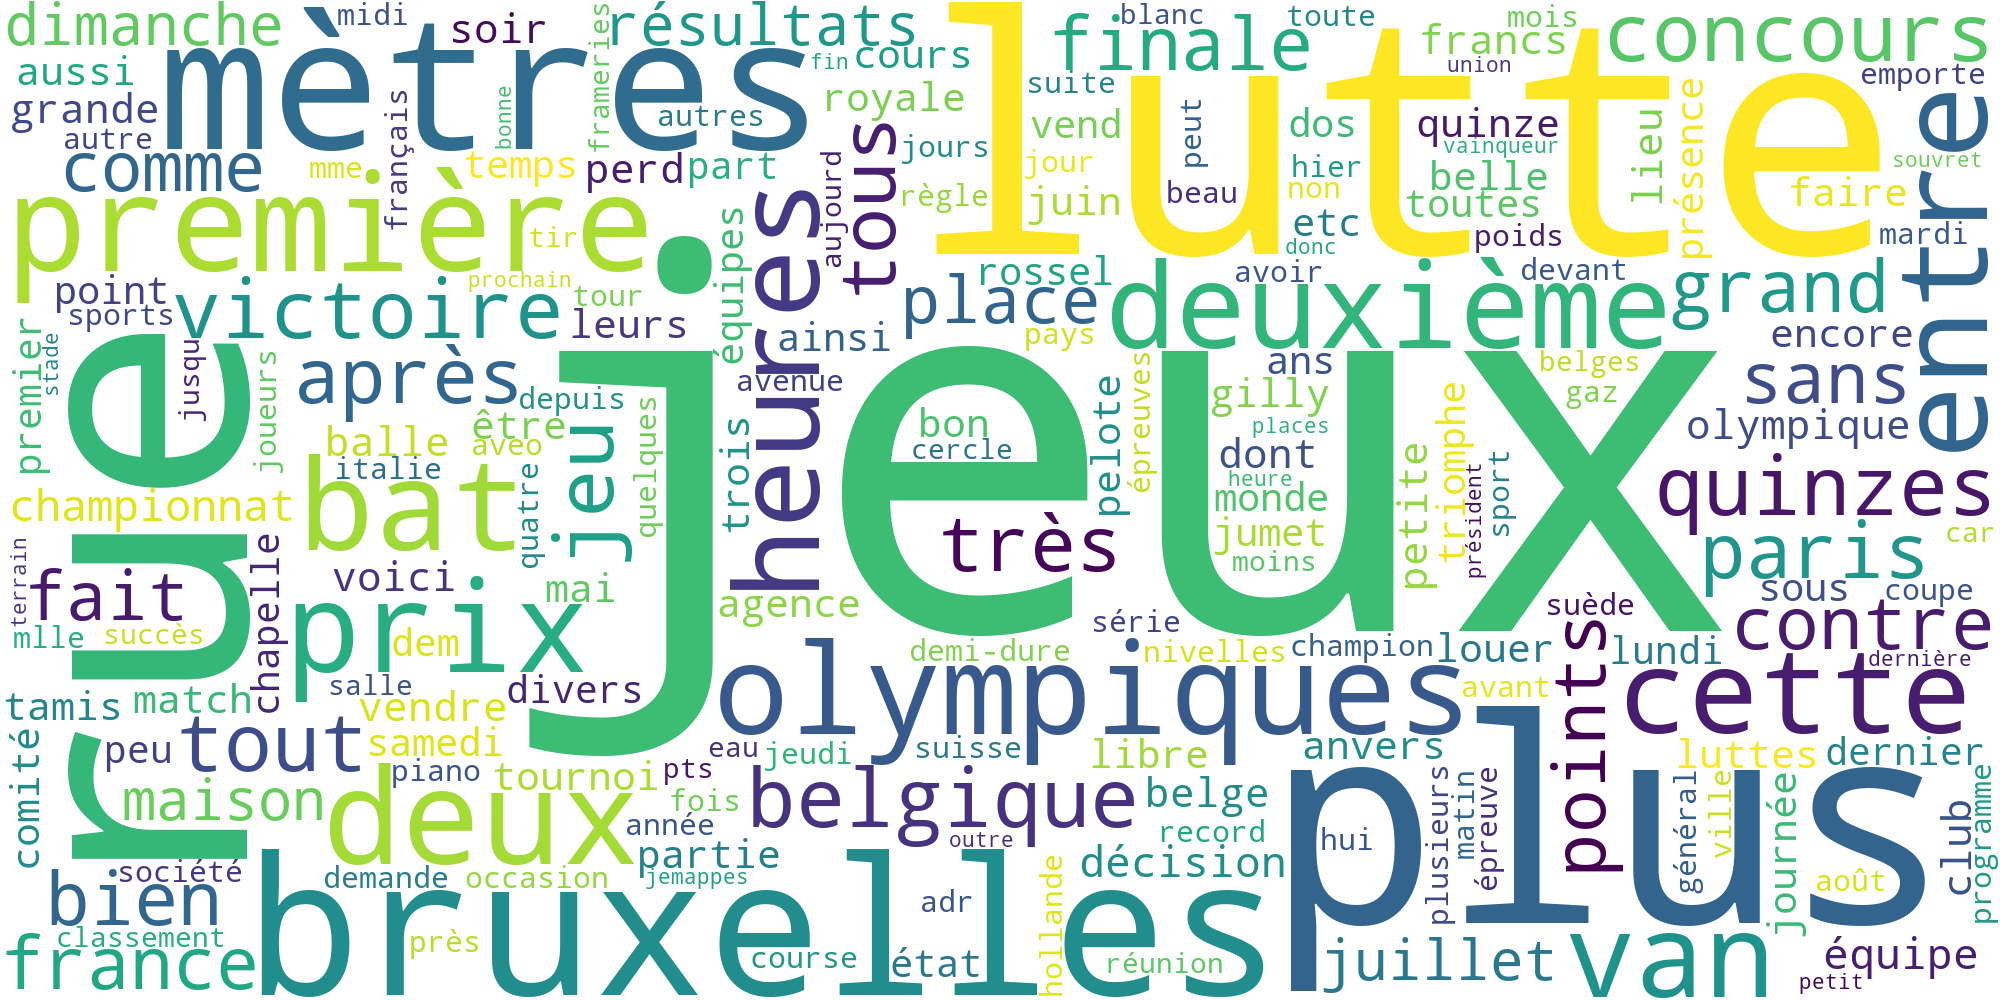

In [26]:
from wordcloud import WordCloud
from IPython.display import Image
import os
# --- 2. Chemin pour sauvegarder ---
output_path = "output_wordcloud"
os.makedirs(output_path, exist_ok=True)
filename = os.path.join(output_path, "wordcloud_corpus.png")



frequencies = Counter(full_clean_text.split())
frequencies = dict(frequencies.most_common(200))

# --- 3. Génération du nuage de mots
cloud = WordCloud(width=2000, height=1000, background_color='white').generate_from_frequencies(frequencies)

# --- 4. Sauvegarde ---
cloud.to_file(filename)

# --- 5. Affichage ---
Image(filename=filename)

## NER (Reconnaissance d'Entités Nomée)

In [27]:
# Chargement du model spacy
import spacy
from collections import Counter
import pandas as pd

# Charger le modèle français (vu en cours)
nlp = spacy.load("fr_core_news_md")


In [28]:
# on applique spacy sur le texte nettoyé
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

# Appliquer à tout le corpus
df["entities"] = df["clean_text"].apply(extract_entities)

df[["clean_text", "entities"]].head()


,clean_text,entities
0,seul marathon flandres lieu cause dos jeux olympiques celui-ci disputé fin mois août programme fête athlétique comportera épreuves suivantes critérium international vitesse plat plat plat addition points obtenus chacune épreuves participation cockuyt jbrochart déjà certaine pourparlers engagés aveo deux -excellents sprintera étrangers challenge kilomètre classement trois hommes mémo cercle challenge relais bêlais suédois bêlais olympique relaie xzoo mètres scratch classement spécial trois hommes clubs déuxième catégorie -jdoté eliallcngc mètres scratch deuxième catégorie challenge concours lancement disque lancement javelot lancement poids aut longueur saut perobo challenge espoirs réservé scolaires plat plat plat lancement poids bras programme admirable originalité doit satisfaire plus difficiles concours tous meilleurs athlètes belges -dès présent assuré comme chaque année stadium connaîtra foule grands jduis union sportive gosselies union sportive gosselies organise lundi juillet fête nationales deux heures demie après-midi magnifique terrain rue jumot grand meeting athlétisme réservé athlètes seconde catégorie débu- nts scolaires affiliés ligue belge atb- jétisme programme figurent los épreuves suivantes scolaires saut hauteur lancement disque côtés américains figureront tencore meilleurs athlètes français parmi lcs- quels dogrello demi-finaliste mètres meut olympiques fcry champion france mètréis nordiste lfascaux demi-miller philips italie aussi représentée fameux negri ambrosini commo chefs file quant suisse eiio déléguera dehors fichwarzenbach strcbi martin prestigieux half-miller seetnd mètres olympique participations athlètes argon tins tchécoslovaques deux fameux hongrois sonfray et- gero ainsi dire certaines tandis qne exhibition extraordinaires champions finlandais bitola nurmi pohrola myrra lehtoncn oj-dre possibilités autres pourparlers toujours cours notamment faire venir suédois wide comme peut rendre compte cette brève énumération meeting darin...,"[(cockuyt jbrochart, PER), (champion france, LOC), (demi-miller philips, ORG), (suisse, LOC), (fichwarzenbach strcbi martin prestigieux half, PER), (sonfray et- gero, PER), (bruxelles, LOC), (compétitiou, LOC), (formidablo lot, MISC), (gilly, LOC), (gilly, LOC), (jumet daurel, PER), (àlontignies-sur-sambre colson, MISC), (vander elst cureghem, PER), (van look etterbeek, LOC), (place solnt, LOC), (van bellingen, PER), (hubert chapelle tramaxau, PER), (nrésençe, PER), (hubert farcienne maufort hontlgny blavicr, PER), (auvelai dufaux employés, PER), (auderlecht, LOC), (anderleoht gas oout banque nationale police pompiers ixelles, PER), (wayaio gas continental, LOC), (van der elst, PER), (gilly van nieuwenho- ven, PER), (méditerranée, LOC), (milan, LOC), (rome, LOC), (nalcs, PER), (rome antique, LOC), (olj inpiades, PER), (nabonaasar, PER), (otî, MISC)]"
1,paris pleines olympiades signifie jeux olympiques lieu cette année france stades colombes ville banlieue dont paris hèure annexe hellénistes contents parce olympiades grec signifie période temps marquée retour jeux olympie non jeux eux-mêmes hellénistes jamais contents iis devraient être car restitution jeux olympiques unè belle chose curieuse hommage sport moderne antiquité fois langue sport parle anglais emprunte grec fâchons reconstituer jeux universels fallu établir méthode organisation monde entier règles épreuves tous pays éliminatoires enfin surveillées associations bref internationale sportive assure uni correspondances entre sections nationales caractère international justement premiers traits jeux helléniques spécialement jeux olympiques evidemment grecs eritendaient internationale comme cette distinction internationalisme antique moderne vérité différence étendue différence quantitative beaucoup plus différence fond monde grec tout petit comparons nôtre bien plus morcelé composé cités non etats question relations entre cités ennemies intérieur hellade conception hellade guerres allia

In [29]:
# Ecraction des personnes (PER)
persons = []

for ents in df["entities"]:
    for ent, label in ents:
        if label == "PER":
            persons.append(ent)

person_freq = Counter(persons)
person_freq.most_common(20)


[('quinzes', 291),
 ('jumet', 47),
 ('rebecq', 32),
 ('paume lebrun', 23),
 ('quaregnon david', 14),
 ('houdeng', 11),
 ('ransart', 11),
 ('gust', 11),
 ('lebout', 10),
 ('valéry', 10),
 ('watson', 10),
 ('atel', 10),
 ('martin', 9),
 ('van', 9),
 ('souvret lecomte', 8),
 ('michel', 8),
 ('dekoker', 7),
 ('henri', 7),
 ('gilbert', 7),
 ('françois', 7)]

In [30]:
# Ecraction des lieux (LOC, GPE)
places = []

for ents in df["entities"]:
    for ent, label in ents:
        if label in ["LOC", "GPE"]:
            places.append(ent)

place_freq = Counter(places)
place_freq.most_common(20)


[('bruxelles', 297),
 ('paris', 155),
 ('belgique', 130),
 ('france', 101),
 ('gilly', 61),
 ('angleterre', 43),
 ('italie', 39),
 ('charleroi', 36),
 ('gilly blancs', 35),
 ('londres', 30),
 ('etats-unis', 29),
 ('gand', 27),
 ('schaerbeek', 24),
 ('canada', 22),
 ('pologne', 21),
 ('liège', 19),
 ('grande-bretagne', 18),
 ('jemappes', 18),
 ('roumanie', 18),
 ('chapelle lez', 17)]

In [31]:
# Ecraction des organisations (ORG)
orgs = []

for ents in df["entities"]:
    for ent, label in ents:
        if label == "ORG":
            orgs.append(ent)

org_freq = Counter(orgs)
org_freq.most_common(20)


[('ford', 11),
 ('lcr', 5),
 ('france belgique', 4),
 ('ter', 3),
 ('fiat', 3),
 ('reich', 3),
 ('nurmi', 3),
 ('tou', 3),
 ('feluy', 3),
 ('adr', 3),
 ('iso', 3),
 ('deg', 3),
 ('antomobilo club milan', 2),
 ('france angleterre', 2),
 ('fio', 2),
 ('yacht club belgique', 2),
 ('mètrss', 2),
 ('rechas', 2),
 ('oourse', 2),
 ('france norvège', 2)]

[('de', 15308),
 ('-', 13120),
 ('kw', 9972),
 ('a', 9197),
 ('et', 9094),
 ('la', 8946),
 ('l', 6666),
 ('le', 6332),
 ('les', 5568),
 ('d', 4683),
 ('à', 4363),
 ('jeux', 4353),
 ('du', 3940),
 ('par', 3915),
 ('s', 3776),
 ('des', 3757),
 ('en', 3637),
 ('pour', 3369),
 ('i', 2974),
 ('un', 2629)]

[('sunlight', 'savon'),
 ('côtières', 'indiquées'),
 ('rex', 'ingram'),
 ('détaillés', 'complets'),
 ('malles', 'congolaises'),
 ('aldo', 'nadi'),
 ('congolaises', 'paquebots'),
 ('stations', 'côtières'),
 ('mentionnés', 'cidessous'),
 ('montes', 'probables'),
 ('carabiniers', 'reunis'),
 ('arne', 'borg'),
 ('lundis', 'mercredis'),
 ('mercredis', 'vendredis'),
 ('centimes', 'additionnels'),
 ('pages', 'illustrations'),
 ('new', 'york'),
 ('ingram', 'tiré'),
 ('composant', 'principalement'),
 ('illustrations', 'portraits')]

## Récupération de tous les articles de la page d'accueil



## Création d'un dataframe avec les liens et les titres des articles


## Téléchargement d'un article et affichage du texte

### Nettoyage du texte à l'aide d'expressions régulières

### Création d'un fichier avec le contenu de l'article


## Pour en savoir plus